<a href="https://colab.research.google.com/github/ArmaanKay/Project-portfolio/blob/main/NNDL_CW_180359246.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing environment

In [ ]:
#!pip install myutils
import sys
import my_utils as mu
#IF RUNNING ON COLAB, UPLOAD "my_utils" BEFORE RUNNING OR ELSE WILL NOT FUNCTION
import collections
from collections import defaultdict
from IPython import display
import math
from matplotlib import pyplot as plt
import time
d2l = sys.modules[__name__]
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 1. Read dataset and create dataloaders: 5%



In [ ]:
def load_data_cifar10(batch_size, resize=None, validation_split=0.1):
    """Download the CIFAR10 dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))

    trans_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomGrayscale(p=0.05),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trans_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    cifar10_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans_train, download=True)

    # Split the training set into training and validation subsets
    num_train = len(cifar10_train)
    indices = list(range(num_train))
    split = int(np.floor(validation_split * num_train))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]

    train_sampler = data.sampler.SubsetRandomSampler(train_idx)
    val_sampler = data.sampler.SubsetRandomSampler(val_idx)

    cifar10_train_full = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans_train, download=True)

    cifar10_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=trans_test, download=True)

    train_loader = data.DataLoader(
        cifar10_train, batch_size=batch_size, sampler=train_sampler,
        num_workers=2, pin_memory=True
    )
    val_loader = data.DataLoader(
        cifar10_train, batch_size=batch_size, sampler=val_sampler,
        num_workers=2, pin_memory=True
    )
    train_loader_full = data.DataLoader(
        cifar10_train_full, batch_size=batch_size, shuffle=True,
        num_workers=2, pin_memory=True
    )
    test_loader = data.DataLoader(
        cifar10_test, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=True
    )

    return train_loader, val_loader, train_loader_full, test_loader


In [ ]:
batch_size = 256
train_loader, val_loader, train_loader_full, test_loader = load_data_cifar10(batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(train_loader), len(val_loader), len(train_loader_full), len(test_loader)

(176, 20, 196, 40)

# 2. Create the model: 40%

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k):
        super(Block, self).__init__()

        self.spatial_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(in_channels, 20)
        self.linear2 = nn.Linear(20, 20)
        self.linear3 = nn.Linear(20, k)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.batchnorm = nn.BatchNorm2d(out_channels)

        self.conv_layers = nn.ModuleList([nn.Sequential(
                                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(out_channels),  # Add BatchNorm
                                    nn.ReLU(inplace=True)  # Add ReLU
                                ) for _ in range(k)])

        self.k = k

    def forward(self, x):

        a = self.spatial_avg_pool(x)
        a = a.view(a.size(0), -1)
        a = self.linear1(a)
        a = self.relu(a)
        a = self.linear2(a)
        a = self.relu(a)
        a = self.linear3(a)
        a = self.relu(a)

        output = 0
        for k in range(self.k):
            conv_output = self.conv_layers[k]
            o = conv_output(x)
            ax = a[:, k].unsqueeze(1).unsqueeze(2).unsqueeze(3)
            conv_a_product = o * ax
            output += conv_a_product

        output = self.batchnorm(output)
        output = self.relu(output)
        output = self.max_pool(output)

        return output

In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Classifier, self).__init__()
        self.spatial_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        f = self.spatial_avg_pool(x)
        f = f.view(f.size(0), -1)
        f = self.fc(f)
        return f

In [ ]:
class ArmaanModel(nn.Module):
    def __init__(self, num_classes):
        super(ArmaanModel, self).__init__()

        # Define the blocks
        self.block1 = Block(in_channels=3, out_channels=64, k=16)
        self.block2 = Block(in_channels=64, out_channels=128, k=16)
        self.block3 = Block(in_channels=128, out_channels=256, k=16)
        self.block4 = Block(in_channels=256, out_channels=256, k=16)
        self.classifier = Classifier(in_channels=256, num_classes=10)

    def forward(self, x):
        # Pass input through blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.classifier(x)

        return x

# 3. Create the loss and optimizer: 5%

In [ ]:
# optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)
# loss = nn.CrossEntropyLoss()

# 4. Write the train script and train the model. Provide in the report: 30%


*   The curves for the evolution of loss
*   The curves for the evolution of training and validation (test) accuracies
*   All training details including hyperparameters used







In [ ]:
# Defined in file: ./chapter_convolutional-neural-networks/lenet.md
def train_ch6(net, train_loader_full, test_loader, num_epochs, lr,
              device=mu.try_gpu()):
    """Train and evaluate a model with CPU or GPU."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)
    loss = nn.CrossEntropyLoss()

    animator = mu.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.Timer()

    for epoch in range(num_epochs):
        metric = mu.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_loader_full):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_loader_full),
                             (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_loader)
        animator.add(epoch+1, (None, None, test_acc))


    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# 5. Final Model accuracy on CIFAR-10 Validation (test) set: 20%

loss 0.295, train acc 0.897, test acc 0.875
616.2 examples/sec on cuda


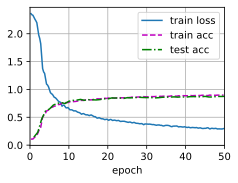

In [ ]:
net = ArmaanModel(num_classes=10)
num_epochs = 50
lr = 0.001

train_ch6(net, train_loader_full, test_loader, num_epochs, lr, device)

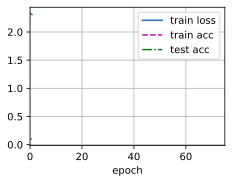

In [ ]:
net = ArmaanModel(num_classes=10)
num_epochs = 75
lr = 0.001

train_ch6(net, train_loader_full, test_loader, num_epochs, lr, device)